In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [11]:
data_path = Path().resolve() / 'xy_data.csv'
df = pd.read_csv(data_path)

x_actual = torch.tensor(df['x'].values, dtype=torch.float32, device=device)
y_actual = torch.tensor(df['y'].values, dtype=torch.float32, device=device)
t_values = torch.linspace(6, 60, len(df), dtype=torch.float32, device=device)

print(f"Data shape: {x_actual.shape}")
print(f"t range: {t_values.min():.4f} to {t_values.max():.4f}")
print(f"Number of points: {len(df)}")

Data shape: torch.Size([1500])
t range: 6.0000 to 60.0000
Number of points: 1500


In [ ]:
theta = torch.tensor(25 * np.pi / 180.0, dtype=torch.float32, requires_grad=True, device=device)
M = torch.tensor(0, dtype=torch.float32, requires_grad=True, device=device)
X = torch.tensor(50, dtype=torch.float32, requires_grad=True, device=device)

optimizer = optim.Adam([theta, M, X], lr=0.01)
criterion = nn.L1Loss()

In [19]:
num_epochs = 15000
print_interval = 500
best_loss = float('inf')
patience = 1000
no_improve_count = 0

print("\n" + "="*60)
print("Starting Training")
print("="*60)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    exp_term = torch.exp(M * torch.abs(t_values))
    sin_03t = torch.sin(0.3 * t_values)

    x_pred = t_values * cos_theta - exp_term * sin_03t * sin_theta + X
    y_pred = 42 + t_values * sin_theta + exp_term * sin_03t * cos_theta

    loss_x = criterion(x_pred, x_actual)
    loss_y = criterion(y_pred, y_actual)
    loss = loss_x + loss_y

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        theta.clamp_(0, 50 * np.pi / 180.0)
        M.clamp_(-0.05, 0.05)
        X.clamp_(0, 100)

    if loss.item() < best_loss:
        best_loss = loss.item()
        no_improve_count = 0
    else:
        no_improve_count += 1

    if (epoch + 1) % print_interval == 0:
        print(f"Epoch {epoch+1:4d}/{num_epochs} | Loss: {loss.item():.6f} | "
              f"θ: {theta.item() * 180/np.pi:.4f}° | M: {M.item():.6f} | X: {X.item():.4f}")

    if no_improve_count >= patience:
        print(f"\nEarly stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
        break

print("\n" + "="*60)
print("Training Complete")
print("="*60)


Starting Training
Epoch  500/15000 | Loss: 25.253511 | θ: 28.3323° | M: 0.021262 | X: 55.7154
Epoch 1000/15000 | Loss: 25.243645 | θ: 28.1552° | M: 0.021435 | X: 54.9761
Epoch 1500/15000 | Loss: 25.243568 | θ: 28.1150° | M: 0.021226 | X: 54.9040
Epoch 2000/15000 | Loss: 25.243410 | θ: 28.1329° | M: 0.020831 | X: 54.9053

Early stopping at epoch 2233 (no improvement for 1000 epochs)

Training Complete


In [20]:
with torch.no_grad():
    theta_deg = theta.item() * 180.0 / np.pi
    m_val = M.item()
    x_val = X.item()
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    exp_term = torch.exp(M * torch.abs(t_values))
    sin_03t = torch.sin(0.3 * t_values)
    x_pred = t_values * cos_theta - exp_term * sin_03t * sin_theta + X
    y_pred = 42 + t_values * sin_theta + exp_term * sin_03t * cos_theta
    final_loss = criterion(x_pred, x_actual) + criterion(y_pred, y_actual)

print(f"\nFinal Parameters:")
print(f"  θ (theta):  {theta_deg:.6f}°")
print(f"  M:          {m_val:.6f}")
print(f"  X:          {x_val:.6f}")
print(f"\nFinal L1 Loss: {final_loss.item():.6f}")


Final Parameters:
  θ (theta):  28.120428°
  M:          0.021304
  X:          54.903419

Final L1 Loss: 25.243410


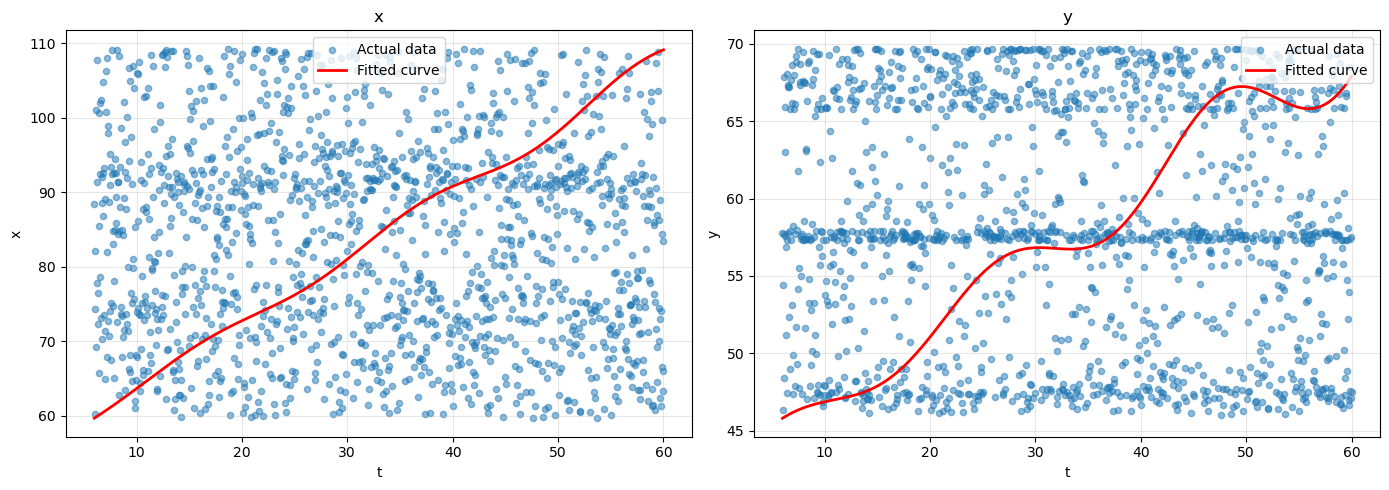

In [22]:
t_plot = np.linspace(6, 60, 500)
t_plot_tensor = torch.tensor(t_plot, dtype=torch.float32, device=device)

with torch.no_grad():
    exp_term_plot = torch.exp(M * torch.abs(t_plot_tensor))
    sin_03t_plot = torch.sin(0.3 * t_plot_tensor)
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    x_plot = t_plot_tensor * cos_theta - exp_term_plot * sin_03t_plot * sin_theta + X
    y_plot = 42 + t_plot_tensor * sin_theta + exp_term_plot * sin_03t_plot * cos_theta

x_plot = x_plot.cpu().numpy()
y_plot = y_plot.cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(t_values.cpu().numpy(), x_actual.cpu().numpy(), alpha=0.5, s=20, label='Actual data')
ax1.plot(t_plot, x_plot, 'r-', linewidth=2, label='Fitted curve')
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('x')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.scatter(t_values.cpu().numpy(), y_actual.cpu().numpy(), alpha=0.5, s=20, label='Actual data')
ax2.plot(t_plot, y_plot, 'r-', linewidth=2, label='Fitted curve')
ax2.set_xlabel('t')
ax2.set_ylabel('y')
ax2.set_title('y')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()